# Практическая задача (50 баллов)

В этой задаче мы будем сравнивать различные итерационные методы для решения систем, как модельных, так и настоящих больших и разреженных.

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
%matplotlib inline

## 1. Модельная плотная матрица (35 баллов)

Начнём с некоторой модельной плотной матрицы. Она будет симметричной положительно определённой, чтобы можно было применять все наши методы, однако собственные числа мы выберем так, чтобы получить довольно большое число обусловленности.

In [3]:
d = np.hstack([1 / np.arange(100, 0, -1), 10])
n = len(d)
Q, _ = np.linalg.qr(np.random.random((n, n)))
A = (Q * d) @ Q.T
b = np.random.random(n)

На всякий случай нарисуем сингулярные числа.

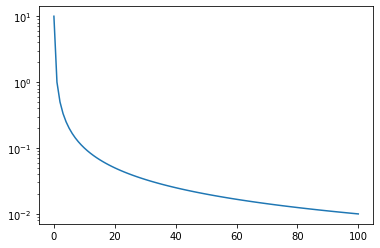

In [4]:
plt.plot(np.linalg.svd(A, compute_uv=False))
_ = plt.semilogy()

### a. Метод простой итерации (7 баллов)

Реализуйте функцию, которая обобщает все варианты метода простой итерации. За это обобщение отвечает параметр `get_dx` &mdash; функция, принимающая невязку $r_k$ и возвращающая вектор $\Delta x \equiv x_{k+1} - x_k$.
Также у функции есть параметр `tol`, соответствующий целевой относительной невязке, то есть величине $\|r_k\|_2/\|b\|_2$.
Наконец, параметр `debug` нужен, чтобы контролировать дебажный вывод. Если передан `debug=True`, на каждой итерации нужно печатать (в свободной форме) номер итерации, относительную невязку и всё, что ещё сочтёте интересным.

В выходном параметре `residual_norms` необходимо вернуть список относительных величин невязок для каждой итерации.

In [5]:
def simple_iteration(A, b, get_dx, x0=None, tol=1e-5, max_iter=None, debug=False):
    """
        Input
            A: dense or sparse square matrix
            b: right part of appropriate size
            get_dx: function computing correction to current solution from current residualresidue
            x0: initial guess for solution
            tol: relative residualresidue to achieve
            max_iter: if specified, no more that this number of iterations will be performed
            debug: if True, output iteration no. and relative residualresidue norm (||r||_2/||b||_2) at each iteration
            
        Output
            x: found approximate solution
            residual_norms: relative residualresidue norms at each iteration
    """
    
    if x0 is None:
        x0 = np.random.normal(size=b.shape[0])
    
    x = x0
    r = b - np.dot(A, x)
    b_norm = np.linalg.norm(b)
    residual_norms = [np.linalg.norm(r) / b_norm]
    step = 0
    while residual_norms[-1] > tol and (max_iter is None or step < max_iter):
        if debug:
            print("step:", step, "residual norm:", residual_norms[-1])
        x = x + get_dx(r)
        r = b - np.dot(A, x)
        residual_norms.append(np.linalg.norm(r) / b_norm)
        step += 1
    
    return x, residual_norms

Используем также вспомогательную функцию, которая будет запускать солвер, печатать время работы и рисовать график сходимости.

In [6]:
def run_solver(solver, A, b, make_get_dx, **kwargs):
    start = time.time()
    get_dx = make_get_dx()
    get_dx_time = time.time()
    x, rs = solver(A, b, get_dx, **kwargs)
    finish = time.time()
    print("Runtime: {:4.2f} secs ({:4.2f} preparation + {:4.2f} iters)".format(
        finish - start,
        get_dx_time - start,
        finish - get_dx_time,
    ))
    if not rs:
        return None, finish - start
    line, = plt.plot(rs)
    plt.xlabel("Iteration no.")
    plt.ylabel("Relative residualresidue")
    _ = plt.semilogy()
    return line, finish - start

### b. Конкретные вариации метода простой итерации

Будем запускать известные нам варианты метода простой итерации.

##### Метод Ричардсона (4 балла)
Начнём с метода Ричардсона. Реализуйте функцию `make_richardson_get_dx(A, tau)`, которая возвращает функцию, соответствующую методу Ричардсона (Richardson iteration) с фиксированным параметром $\tau$.

In [7]:
def make_richardson_get_dx(A, tau):
    """
        Input
            A: square matrix
            tau: parameter of Richardson iteration

        Output
            get_dx: function mapping r to Δx corresponding to Richardson iteration
    """
    get_dx = lambda r: tau * r
    return get_dx

Помня, что старшее и младшее собственные (и сингулярные) числа матрицы $A$ равны $10$ и $10^{-2}$ соответственно,
выберите 4 разных варианта для $\tau$ из интервала, в котором гарантируется сходимость метода, включая оптимальное значение $\tau$. Прокомментируйте полученный результат.

**Решение:** из лекции 10 знаем, что для метода Ричардсона гарантируется сходимость при $\tau \in (0; \frac{2}{\lambda_{max}(A)})$

Runtime: 0.12 secs (0.00 preparation + 0.12 iters)
Runtime: 0.11 secs (0.00 preparation + 0.11 iters)
Runtime: 0.06 secs (0.00 preparation + 0.06 iters)


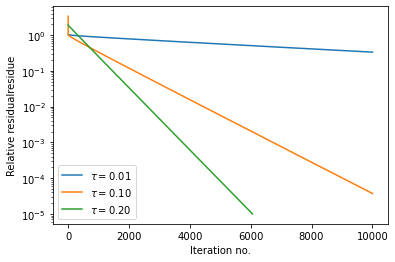

In [8]:
taus = [0.01, 0.1, 2 / (10 + 1e-2)]
lines = []
labels = []
for tau in taus:
    line, _ = run_solver(simple_iteration, A, b, lambda: make_richardson_get_dx(A, tau), max_iter=10000)
    lines.append(line)
    labels.append("$\\tau = {:4.2f}$".format(tau))
_ = plt.legend(lines, labels)

Также попробуйте 1 вариант вне интервала, в котором гарантируется сходимость. Например, отступите от границы интервала на 0.01. Прокомментируйте полученный результат.

Runtime: 0.00 secs (0.00 preparation + 0.00 iters)


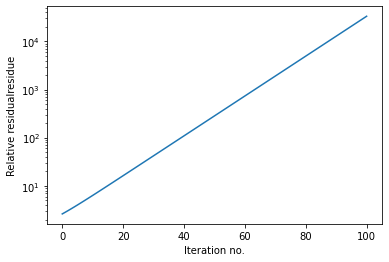

In [9]:
outsider_tau = 2 / 10 + 0.01
_ = run_solver(simple_iteration, A, b, lambda: make_richardson_get_dx(A, outsider_tau), max_iter=100)

**Комментарий:** для ```tau``` вне диапазона получаем норму $||G||_2 = max_i|\lambda_i(I - \tau A)| > 1$, поэтому ошибка имеет возможность экспоненциально возрастать: $||e_{k}|| \leq (1 + \epsilon)^k ||e_0||$ уже не гарантирует сходимости

##### Метод Якоби (4 балла)
Реализуйте функцию `make_jacobi_get_dx(A)`, которая возвращает функцию, соответствующую методу Якоби (то есть $g_{\mathrm{JAC}}(r) = \mathrm{diag}(A)^{-1}r$).

In [10]:
def make_jacobi_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to Jacobi method
    """
    get_dx = lambda r: r / np.diag(A)
    return get_dx

Запустим метод на нашей матрице. Объясните (неформально) полученный результат.

Runtime: 0.00 secs (0.00 preparation + 0.00 iters)


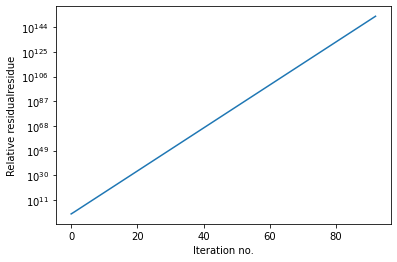

In [11]:
_ = run_solver(simple_iteration, A, b, lambda: make_jacobi_get_dx(A), max_iter=100)

**Объяснение (нефомальное):** проверим матрицу на диагональное преобладание (см. Ячейку ниже). Матрица очень далека от того, чтобы быть примерно-диагональной-плюс-шумы, поэтому сходимость метода Якоби гарантировать не можем.

In [12]:
outer = np.abs(A).sum() - np.abs(np.diag(A)).sum()
min_diag = np.abs(np.max(np.diag(A)))
print(outer, min_diag)

641.9713374903096 1.2158424633865585


##### Метод Гаусса-Зейделя (4 балла)

Реализуйте функцию `make_gauss_seidel_get_dx(A)`, которая возвращает функцию `get_dx`, соответствующую методу Гаусса-Зейделя.

In [13]:
from scipy.linalg import solve_triangular

def make_gauss_seidel_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to Gauss--Seidel method
    """
    get_dx = lambda r: np.dot(solve_triangular(np.tril(A), np.eye(A.shape[0]), lower=True), r)
    
    return get_dx

Запустим метод.

Runtime: 0.70 secs (0.00 preparation + 0.70 iters)


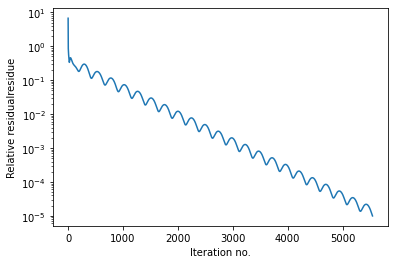

In [14]:
_ = run_solver(simple_iteration, A, b, lambda: make_gauss_seidel_get_dx(A))

##### Метод скорейшего спуска (4 балла)

Реализуйте функцию `make_steepest_descent_get_dx(A)`, которая возвращает функцию, соответствующую методу скорейшего спуска.

In [15]:
y = np.array([1, 2, 3])
X = np.array([[1,0,0],[0,2,0],[0,0,3]])
np.dot(y, np.dot(X, y))

36

In [16]:
def make_steepest_descent_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to steepest descent method
    """
    get_dx = lambda r_k: (np.dot(r_k, r_k) / np.dot(r_k, np.dot(A, r_k))) * r_k
    return get_dx

Запустим метод скорейшего спуска.

Runtime: 0.05 secs (0.00 preparation + 0.05 iters)


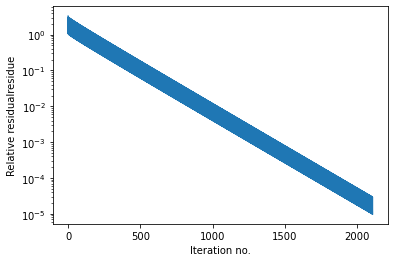

In [17]:
_ = run_solver(simple_iteration, A, b, lambda: make_steepest_descent_get_dx(A))

##### Метод сопряжённых градиентов (8 баллов)

Реализуйте обёртку над функцией `scipy.sparse.linalg.cg`. Набор параметров почти совпадает с функцией `simple_iteration`, за исключением некоторых деталей.
 1. Третий параметр называется `preconditioner` вместо `get_dx`, но играет похожую роль. Он должен редставлять собой объект класса [LinearOperator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html). Такие объекты имеют `.shape` и умеют делать умножение на вектор справа с помощью операции `@`. Этот параметр нужно передать в `scipy.sparse.linalg.cg`. В случае, когда он не None, будет запускаться [предобусловленный метод сопряжённых градиентов](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_preconditioned_conjugate_gradient_method).
 2. Есть параметр `compute_residual`, отвечающий за необходимость вычислять относительные невязки (это вычисление требует дополнительного матрично-векторного умножения, поэтому увеличивает трудоёмкость). Если `compute_residual == False`, возвращаемый список `residual_norms` должен быть пуст.
 
При написании данной функции пользуйтесь [документацией](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html#scipy.sparse.linalg.cg) для `scipy.sparse.linalg.cg`. Особенно обратите внимание на параметр `callback`, он вам точно понадобится.

In [18]:
def modify_list(val):
    a.append(val)
a = []
val = 5
modify_list(val)
print(a)

[5]


In [34]:
import inspect

def conjugate_gradients(A, b, preconditioner=None, x0=None, tol=1e-5, max_iter=None, debug=False, compute_residual=True):
    """
        Input
            A: dense or sparse square matrix
            b: right part of equation
            preconditioner: scipy.sparse.linalg.LinearOperator
            x0: initial guess for solution
            tol: relative residual to achieve
            max_iter: if specified, no more that this number of iterations will be performed
            debug: if True, output iteration no. and relative residual norm (||r||_2/||b||_2) at each iteration
            compute_residual: whether to compute and output relative residualresidue norms

        Output
            x: found approximate solution
            residual_norms: relative residual norms at each iteration (empty if compute_residualresidues=False)
    """
    residual_norms = []
    # со мной поделились отличным хаком для дебаг-вывода:
    # https://stackoverflow.com/questions/14243579/print-current-residual-from-callback-in-scipy-sparse-linalg-cg
    # https://github.com/scipy/scipy/blob/master/scipy/sparse/linalg/isolve/iterative.py
    def user_callback(x_k):
        frame = inspect.currentframe().f_back
        step = frame.f_locals['iter_']
        
        r_k = frame.f_locals['resid']
        # r_k = b - A @ x_k  # более прямой путь
        
        resid_norm = np.linalg.norm(r_k) / np.linalg.norm(b)
        if debug:
            print("step:", step, "residual norm:", resid_norm)
        if compute_residual:
            residual_norms.append(resid_norm)
    
    if x0 is None:
        #np.zeros(shape=b.shape)
        x0 = np.random.normal(size=b.shape[0])
    
    callback_func = user_callback if compute_residual or debug else lambda x_k: None
    
    x = spla.cg(A, b, x0=x0, M=preconditioner, tol=tol, maxiter=max_iter, callback=callback_func)
    
    return x, residual_norms
    

Запустим метод сопряжённых градиентов на нашей задаче.

step: 2 residual norm: 1.7234011703936623
step: 3 residual norm: 2.386759509795836
step: 4 residual norm: 1.8674484093389363
step: 5 residual norm: 1.1792370512631685
step: 6 residual norm: 0.7297139055178166
step: 7 residual norm: 0.5832126899566612
step: 8 residual norm: 0.2993665392792864
step: 9 residual norm: 0.1651816419758308
step: 10 residual norm: 0.11554340105460154
step: 11 residual norm: 0.6718244472251347
step: 12 residual norm: 0.06865630854725446
step: 13 residual norm: 0.03446260524485518
step: 14 residual norm: 0.023889903414850734
step: 15 residual norm: 0.013253632007548616
step: 16 residual norm: 0.008319137198597101
step: 17 residual norm: 0.004184787782637166
step: 18 residual norm: 0.0050006450312625635
step: 19 residual norm: 0.0026410691240549445
step: 20 residual norm: 0.002174089053767059
step: 21 residual norm: 0.0014134363416754834
step: 22 residual norm: 0.0006805921434015706
step: 23 residual norm: 0.00037787221051452645
step: 24 residual norm: 0.00016120

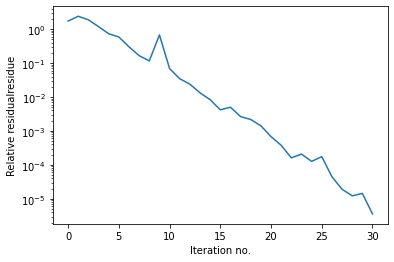

In [20]:
_ = run_solver(conjugate_gradients, A, b, lambda: None, compute_residual=True, debug=True)

## 2. Применение к большим разреженным матрицам (15 баллов)

До сих пор больших проблем со сходимостью методов на тестовой матрице не возникало. Но в практических задачах могут возникать весьма неприятные матрицы. Давайте скачаем [файл G2_circuit.mat](https://sparse.tamu.edu/AMD/G2_circuit) (для удобства мы уже положили его в одну папку с данным ноутбуком; по ссылке можно ознакомиться с шаблоном разреженности матрицы и ее графом) с некоторой разреженной матрицей из коллекции разреженных матриц Флоридского университета https://sparse.tamu.edu. Отметим, что выбранная матрица соответствует некоторой задаче физической симуляции работы интегральной схемы (вероятно из процессора AMD).

На сайте коллекции можно не только сортировать матрицы по размерам и числу ненулевых элементов, но и фильтровать по разным свойствам. Например, упомянутая матрица является симметричной положительно определённой, что будет нам очень на руку.

Загрузим файл (он в матлабовском формате .mat, но scipy справится). Также выберем некоторый случайный вектор в качестве правой части.

In [21]:
import scipy.io
A = scipy.io.loadmat("data/G2_circuit.mat")["Problem"][0][0][2]
assert A.shape[0] == A.shape[1]
n = A.shape[0]
print("{} x {}, nnz: {}, density: {:.3}".format(n, n, A.nnz, A.nnz / float(n**2)))
b = np.random.random(n)

150102 x 150102, nnz: 726674, density: 3.23e-05


### a. Прямой солвер (5 баллов)

Вычислите разреженное LU-разложение матрицы $A$, а затем с помощью него точное решение задачи $Ax = b$

In [22]:
def solve_exact(A, b):
    """
        Solve system Ax=b using sparse LU decomposition.

        Input
            A: square sparse matrix
            b: right part

        Output
            x: solution of Ax=b
    """
    return spla.splu(A).solve(b)

Замерим время работы прямого алгоритма. 

In [23]:
%timeit -r 1 -n 1 exact = solve_exact(A, b)

5.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Будем пробовать применять известные нам вариации метода простой итерации. Для начала запустим метод наискорейшего спуска.

In [24]:
# kernel died. хорошо хоть сохранился до запуска
# _ = run_solver(simple_iteration, A, b, lambda: make_steepest_descent_get_dx(A), max_iter=1000)

Судя по всему, матрица очень плохо обусловлена, и обычным методом простой итерации решить с ней систему будет нетривиально. Что же,  у нас есть серебряная пуля: метод сопряжённых градиентов. Запустите его!

Runtime: 3.12 secs (0.00 preparation + 3.12 iters)


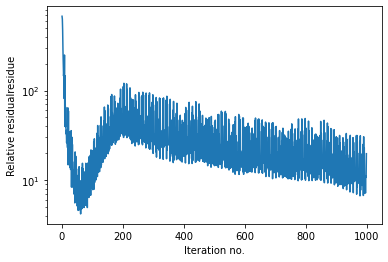

In [25]:
_ = run_solver(conjugate_gradients, A, b, lambda: None, max_iter=1000)

Кажется, матрица столь плохо обусловлена, что нас не спасает даже метод сопряжённых градиентов.
Есть ещё один шанс в таком случае &mdash; попробовать применить предобуславливатель.

### b. Предобусловленный метод сопряжённых градиентов (15 баллов)


##### Построение предобуславливателя (10 баллов)

Классический предобуславливатель для CG &mdash; это incomplete LU (ILU) decomposition, в котором по различным правилам отбрасываются возникающие заполнения. Реализуйте ILU-предобуславливатель, используя функцию `scipy.sparse.linalg.spilu`.
Параметры `fill_factor` и `drop_tol` нужны для настройки метода ILU. `fill_factor` отвечает за то, во сколько раз можно увеличить заполнение матрицы при вычислении неполного LU-разложения. `drop_tol` &mdash; это относительная величина элементов, меньше которой мы считаем их нулями. Эти параметры нужно передать в функцию `spilu`.

Не забудьте, что функция `make_ilu_prec` должна вернуть `scipy.sparse.linalg.LinearOperator`!

In [26]:
def make_ilu_prec(A, fill_factor=10, drop_tol=1e-4):
    """
        Input:
            A: sparse square matrix
            fill_factor: ILU fill ratio upper bound
            drop_tol: ILU drop tolerance
            
        Output:
            preconditioner: LinearOperator
    """
    
    
    ilu = lambda x: spla.spilu(A, drop_tol=drop_tol, fill_factor=fill_factor).solve(x)
    precond = spla.LinearOperator(A.shape, ilu)
    
    return precond

Запустим метод на нашей матрице.

In [27]:
_ = run_solver(conjugate_gradients, A, b, lambda: make_ilu_prec(A), max_iter=100, debug=True)

step: 2 residual norm: 158.22316651640892
step: 3 residual norm: 96.08244072684683
step: 4 residual norm: 65.8433586754419
step: 5 residual norm: 26.12854366226459
step: 6 residual norm: 48.22240130849943
step: 7 residual norm: 33.002479971239275
step: 8 residual norm: 40.47955350342897


KeyboardInterrupt: 

Метод расходится! Кажется, нас уже ничего не спасёт. Но ILU-предобуславливатель может быть достаточно чувствителен к параметрам `fill_factor` и `drop_tol`. Переберём параметры на сетке 3 на 3 `[10, 20, 50] x [1e-4, 1e-5, 1e-6]`.

In [ ]:
plt.figure(figsize=(15,8))
lines = []
labels = []
for ff in [10, 20, 50]:
    for dt in [1e-4, 1e-5, 1e-6]:
        print("Fill factor {}, drop tolerance {}".format(ff, dt))
        make_prec = lambda: make_ilu_prec(A, fill_factor=ff, drop_tol=dt)
        line, t = run_solver(conjugate_gradients, A, b, make_prec, max_iter=100)
        lines.append(line)
        labels.append("ff {}, dt {:2.0e}, t {:4.2f}".format(ff, dt, t))

_ = plt.legend(lines, labels)

Объясните, как согласуется наблюдаемый эффект немонотонности невязки с тем, что на каждой итерации подпространство Крылова увеличивается, и найденное приближение должно быть ближе к решению.

**Объяснение:** к сожалению, только на пальцах, но вроде суть ясна: по сути, единственное требование к невязке, которые мы предъявляем - её ортогональность текущему подпространству Крылова $K_k$ (так как это требование - переформулировка минимизации функционала энергии). Поэтому может возникнуть такая ситуация: пусть $r_k \in K_3 / (K_3 \cap K_2)$, то есть лежит "ровно" в $K_3$. Тогда она будет удовлетворять условию ортогональности для $k \leq 2$, а для $k = 3$ уже придётся искать новую невязку, и не факт, что она будет хорошей по норме, главное, что она должна быть ортогональна $K_3$. То есть, насколько я понял, метод вообще нам не гарантирует монотонной сходимости по норме невязки, просто так получается, что он быстрый, потому что он вычислительно быстрее остальных (при правильном подборе гиперпарметров), и при этом невязка в основном убывает.

##### Preconditioned CG vs sparse LU (5 баллов)

Для каких параметров метод сошёлся? [**Ответ:** метод сходится при Fill_factor = 50.] Замерьте для всех сходящихся вариантов время работы без вычисления невязок (передайте `compute_residual=False` в функцию `run_solver`). В идеале вы должны (несильно, но всё же) победить по времени вычисления прямой метод (через полное LU), который вы использовали в начале раздела.

In [41]:
x_cg = run_solver(conjugate_gradients, A, b, lambda: make_ilu_prec(A, fill_factor=50, drop_tol=1e-5),
                  max_iter=100, compute_residual=False, debug=False, tol=1e-5)

Runtime: 44.69 secs (4.17 preparation + 40.52 iters)


In [42]:
%timeit -r 1 -n 1 exact = solve_exact(A, b)

4.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
